# Извлечение именованных сущностией

In [1]:
test_file = '/NLP/data/factRuEval-2016-master/factRuEval_train.conll'
train_file = '/NLP/data/factRuEval-2016-master/factRuEval_test.conll'

In [2]:
from keras.models import Sequential
import numpy as np
from keras.preprocessing import sequence
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers import Merge
from keras.backend import tf

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus.reader.conll import *
train_reader = ConllCorpusReader(root = '', fileids = [train_file], columntypes = ['ignore', 'ignore', 'words', 'pos', 'chunk'])
test_reader = ConllCorpusReader(root = '', fileids = [test_file], columntypes = ['ignore', 'ignore', 'words', 'pos', 'chunk'])


train_sents = list(train_reader.iob_sents())
test_sents = list(test_reader.iob_sents())

print(train_sents[0])

# all_x = []
# point = []
# for line in raw:
#     stripped_line = line.strip().split(' ')
#     point.append(stripped_line)
#     if line == '\n':
#         all_x.append(point[:-1])
#         point = []
# all_x = all_x[:-1]
# print(all_x[0])

def encode(x, n):
    result = np.zeros(n)
    result[x] = 1
    return result

Using TensorFlow backend.


[('Александр', 'NOUN', 'B-Person'), ('Вертинский', 'NOUN', 'E-Person'), ('.', 'Other', 'O'), ('«', 'Other', 'O'), ('Я', 'NPRO', 'O'), ('не', 'PRCL', 'O'), ('знать', 'VERB', 'O'), (',', 'Other', 'O'), ('зачем', 'ADVB', 'O'), ('и', 'CONJ', 'O'), ('кома', 'NOUN', 'O'), ('это', 'PRCL', 'O'), ('нужно', 'PRED', 'O'), ('…', 'Other', 'O'), ('»', 'Other', 'O')]


In [3]:
X_train = [[word[0].lower()  for word in sent ] for sent in train_sents ]
X_test = [[word[0].lower()  for word in sent ] for sent in test_sents ]
Y_train = [[word[2]  for word in sent ] for sent in train_sents ]
Y_test = [[word[2]  for word in sent ] for sent in test_sents ]
words = list(set([word[0].lower() for sent in train_sents+test_sents for word in sent ]))
word2ind = {word: index for index, word in enumerate(words)}
ind2word = {index: word for index, word in enumerate(words)}
labels = list(set([word[2] for sent in train_sents for word in sent ]))
label2ind = {label: (index + 1) for index, label in enumerate(labels)}
ind2label = {(index + 1): label for index, label in enumerate(labels)}
maxlen = max([len(sent) for sent in train_sents+test_sents])

In [4]:
ind2label

{1: 'E-Facility',
 2: 'I-Org',
 3: 'E-Person',
 4: 'I-Person',
 5: 'O',
 6: 'E-Project',
 7: 'B-LocOrg',
 8: 'I-Location',
 9: 'E-LocOrg',
 10: 'I-LocOrg',
 11: 'B-Facility',
 12: 'E-Location',
 13: 'E-Org',
 14: 'I-Project',
 15: 'B-Location',
 16: 'B-Org',
 17: 'B-Project',
 18: 'B-Person'}

In [5]:
X_train_enc = [[word2ind[c] for c in x] for x in X_train]
X_test_enc = [[word2ind[c] for c in x] for x in X_test]
max_label = max(label2ind.values())  + 1

Y_train_enc = [[0] * (maxlen - len(ey)) + [label2ind[c] for c in ey] for ey in Y_train]
Y_train_enc = [[encode(c, max_label) for c in ey] for ey in Y_train_enc]

Y_test_enc = [[0] * (maxlen - len(ey)) + [label2ind[c] for c in ey] for ey in Y_test]
Y_test_enc = [[encode(c, max_label) for c in ey] for ey in Y_test_enc]

X_train_pad = pad_sequences(X_train_enc, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_enc, maxlen=maxlen)

Y_test_pad = pad_sequences(Y_test_enc, maxlen=maxlen)
Y_train_pad = pad_sequences(Y_train_enc, maxlen=maxlen)



print ('Training and testing tensor shapes:')
print (X_train_pad.shape, X_test_pad.shape, Y_train_pad.shape, Y_test_pad.shape)

X_train = X_train_pad
X_test = X_test_pad
Y_train = Y_train_pad
Y_test = Y_test_pad

Training and testing tensor shapes:
(3138, 87) (1769, 87) (3138, 87, 19) (1769, 87, 19)


In [6]:
max_features = len(word2ind)
embedding_size = 128
hidden_size = 128
out_size = len(label2ind)  + 1
nb_epoch = 10
batch_size = 32

In [7]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Bidirectional(LSTM(hidden_size, return_sequences = True)))
model.add(TimeDistributed(Dense(out_size, activation = 'softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_split=0.1)

Train on 2824 samples, validate on 314 samples
Epoch 1/10
2824/2824 [==============================] - 42s - loss: 0.4649 - acc: 0.9099 - val_loss: 0.1652 - val_acc: 0.9652

In [8]:
score = model.evaluate(X_test, Y_test)

print('Test score:', score[0])
print('Test accuracy:', score[1])

1760/1769 [============================>.] - ETA: 0s 

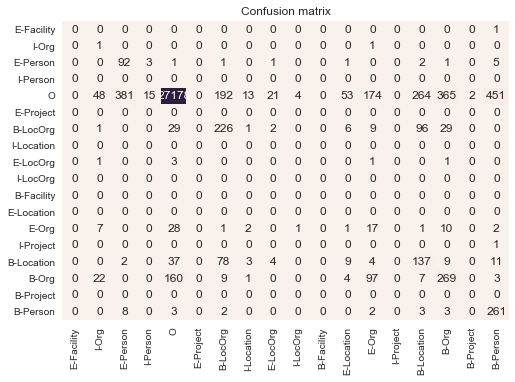

In [9]:
pred = model.predict(X_test)
Y_pred = []
Y_test_1dim = []
for i in range(len(pred)):
    for j in range(len(pred[i])):
        pred_label = np.argmax(pred[i][j])
        if pred_label != 0:
            Y_pred.append(ind2label[pred_label])
        else:
            Y_pred.append('PAD')
        test_label = np.argmax(Y_test[i][j])
        if test_label != 0:
            Y_test_1dim.append(ind2label[test_label])
        else:
            Y_test_1dim.append('PAD')





sns.heatmap(data=confusion_matrix(Y_pred, Y_test_1dim, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [10]:
print (classification_report(Y_pred, Y_test_1dim))

             precision    recall  f1-score   support

   B-LocOrg       0.44      0.57      0.50       399
 B-Location       0.27      0.47      0.34       294
      B-Org       0.38      0.47      0.42       572
   B-Person       0.35      0.93      0.51       282
  B-Project       0.00      0.00      0.00         0
 E-Facility       0.00      0.00      0.00         1
   E-LocOrg       0.00      0.00      0.00         6
 E-Location       0.00      0.00      0.00         0
      E-Org       0.05      0.24      0.09        70
   E-Person       0.19      0.86      0.31       107
   I-LocOrg       0.00      0.00      0.00         0
 I-Location       0.00      0.00      0.00         0
      I-Org       0.01      0.50      0.02         2
   I-Person       0.00      0.00      0.00         0
  I-Project       0.00      0.00      0.00         1
          O       0.99      0.93      0.96     29161
        PAD       1.00      1.00      1.00    123008

avg / total       0.99      0.98      0.99  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
